In [86]:
## Preloads
using Statistics
using FFTW
using Distributed
using Plots
using BenchmarkTools
using Profile
using LinearAlgebra
using Measures
using HDF5
using Plots
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
using DHC_2DUtils
using MLDatasets
using Images
using HDF5
theme(:dark)

In [33]:
# generate an image of a rod with some position, length, position angle,
# and FWHM
function rod(xcen, ycen, length, pa, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    dtor = pi/180
    # -------- define a unit vector in direction of rod at position angle pa
    ux = sin(pa*dtor)   #  0 deg is up
    uy = cos(pa*dtor)   # 90 deg to the right

    # -------- distance parallel and perpendicular to 
    dpara =  ux.*sx + uy.*sy
    dperp = -uy.*sx + ux.*sy
    
    dpara[abs.(dpara).-length .<0] .= 0
    dpara = abs.(dpara)
    dpara .= min.(abs.(dpara.-length),dpara)
    
    rodimage = exp.(-(dperp.^2+dpara.^2)./(2*sig.^2))

    return rodimage
end

rod (generic function with 1 method)

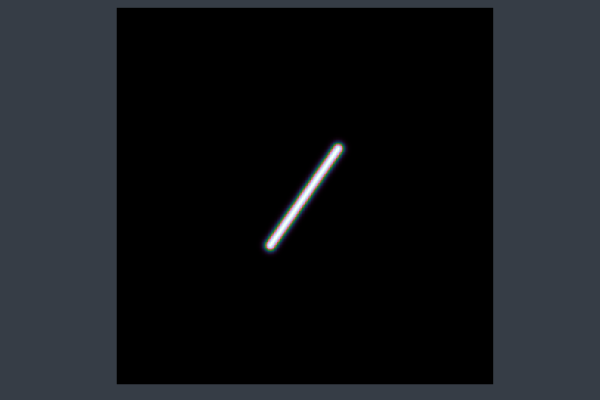

In [39]:
Plots.plot(Plots.heatmap(
    rod(0,0,40,35,6),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [120]:
# generate an image of a rod with some position, length, position angle,
# and FWHM
function rod_half(xcen, ycen, length, pa, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    dtor = pi/180
    # -------- define a unit vector in direction of rod at position angle pa
    ux = cos(pa*dtor)   # 90 deg is up
    uy = sin(pa*dtor)   # 0 deg to the right

    # -------- distance parallel and perpendicular to 
    dpara =  ux.*sx + uy.*sy .- length
    dperp = -uy.*sx + ux.*sy
    
    dpara[abs.(dpara).-length .<0] .= 0
    dpara = abs.(dpara)
    dpara .= min.(abs.(dpara.-length),dpara)
    
    rodimage = exp.(-(dperp.^2+dpara.^2)./(2*sig.^2))

    return rodimage
end

rod_half (generic function with 1 method)

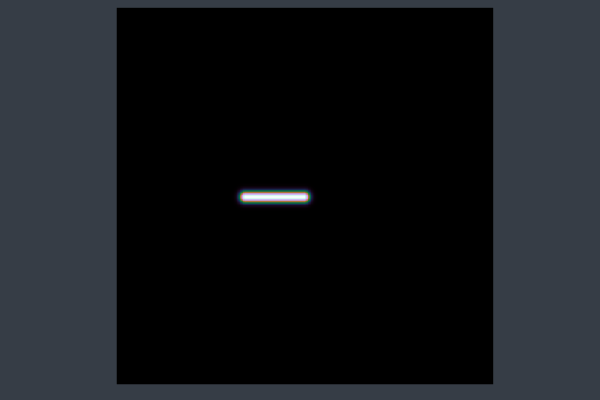

In [119]:
Plots.plot(Plots.heatmap(
    max.(rod_half(0,0,20,180,6),rod_half(0,0,20,180,6)),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [100]:
addprocs(7)

7-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8

In [121]:
bank = fink_filter_bank(1,8,nx=256,wd=2)

h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/filters", bank[1])
h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/J_L", bank[2]["J_L"])
h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/psi_index", bank[2]["psi_index"])
h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/phi_index", [bank[2]["phi_index"]])

In [122]:
@everywhere begin
    using Statistics
    using LinearAlgebra
    using Distributed
    push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
    using DHC_2DUtils
    using FFTW
    using Images
    using Interpolations
    using DSP
    using ProgressMeter
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    # generate an image of a rod with some position, length, position angle,
    # and FWHM
    function rod_half(xcen, ycen, length, pa, fwhm)
        nx = 256
        xbox = 1:nx
        ybox = 1:nx
        xbox = xbox.-nx/2 .+xcen
        ybox = ybox.-nx/2 .+ycen

        sx  = xbox' .* ones(size(ybox)[1])
        sy  = ones(size(xbox)[1])' .* ybox

        sig = fwhm/2.355
        dtor = pi/180
        # -------- define a unit vector in direction of rod at position angle pa
        ux = cos(pa*dtor)   # 90 deg is up
        uy = sin(pa*dtor)   # 0 deg to the right

        # -------- distance parallel and perpendicular to 
        dpara =  ux.*sx + uy.*sy .- length
        dperp = -uy.*sx + ux.*sy

        dpara[abs.(dpara).-length .<0] .= 0
        dpara = abs.(dpara)
        dpara .= min.(abs.(dpara.-length),dpara)

        rodimage = exp.(-(dperp.^2+dpara.^2)./(2*sig.^2))

        return rodimage
    end
    
    function corner_WST(inputs)
        sig, del = inputs
        image = max.(rod_half(0,0,20,sig+del/2,6),rod_half(0,0,20,sig-del/2,6))
        WST = DHC_compute(image, filter_hash,doS2=false)
        power = sum(image.^2)
        return WST, [sig, del, power]
    end
end
        
rod_DHC_out = @showprogress pmap(corner_WST, Iterators.product(0:1:360,0:1:360))
coeff = getindex.(rod_DHC_out, 1);
labels = getindex.(rod_DHC_out, 2);

coeff_out = hcat(coeff...)
labels_out = hcat(labels...)

h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/coeffs", coeff_out)
h5write("../scratch_AKS/paper_data/corner_rod.h5", "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:17:293:57


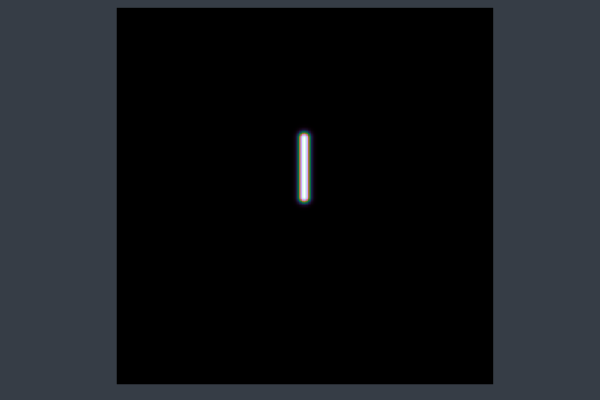

In [472]:
Plots.plot(Plots.heatmap(
    max.(rod_half(0,0,20,0+90,6),rod_half(0,0,20,0+90,6)),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [483]:
export_images = zeros(128*9,128*9)
for (indx_i,i) in enumerate(360:-45:0)
    for (indx_j,j) in enumerate(0:45:360)
        image = max.(rod_half(0,0,20,i+j/2+90,6),rod_half(0,0,20,i-j/2+90,6))
        export_images[(indx_i-1)*128+1:indx_i*128,(indx_j-1)*128+1:indx_j*128] .= image[64:191,64:191]
    end
end

In [484]:
h5write("../scratch_AKS/paper_data/images.h5", "main/data", export_images)

In [134]:
using Plots

function compute_bernstein(i,n; steps=100)
    return [binomial(n,i)*t^i*(1-t)^(n-i) for t in LinRange(0,1,steps)]
end

function compute_bernstein_poly(px,py; steps=100)
    n = length(px)-1
    bernsteins = [compute_bernstein(i,n) for i=0:n]
    x_vals = [sum(px[k]*bernsteins[k][t] for k=1:n+1) for t=1:steps]
    y_vals = [sum(py[k]*bernsteins[k][t] for k=1:n+1) for t=1:steps]
    return x_vals, y_vals
end

function plot_with_bernstein(px,py; steps=100, subplot=1)
    x_vals, y_vals = compute_bernstein_poly(px,py; steps=steps)
    plot!(x_vals, y_vals, color=:blue, label="",subplot=subplot)
end

function main()
    px = [0, 3, 6]
    py = [0, 6, 0]

    plot(;size=(700,500), axisratio=:equal, legendfont=font(13))
    plot!(px, py, linetype=:scatter, label="control points")
    plot_with_bernstein(px,py)
end

main (generic function with 1 method)

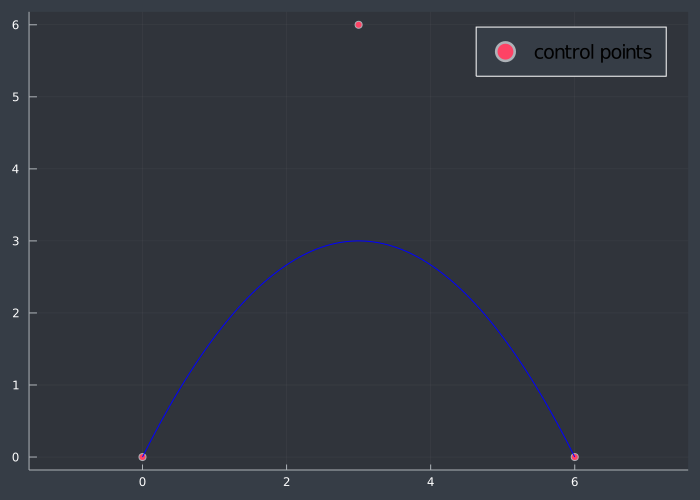

In [135]:
main()

In [312]:
function perp(val)
    return (-val[2], val[1])
end

function getPosOnBentLine(lineStart, lineEnd, t, bendFactor, pivot)
    lineDir = lineEnd - lineStart
    lineLength = sqrt(sum(lineDir.^2))
    circleRad = lineLength / (bendFactor * 2 * pi);
    circleCenter = lineStart .+  (lineEnd .- lineStart)  .* pivot
   
    angle = pi + bendFactor * (t-pivot) * 2 * pi;
    posOnCircle = circleCenter .+ [cos(angle), sin(angle)] .* circleRad .+ [circleRad,0];

    return posOnCircle
end

getPosOnBentLine (generic function with 1 method)

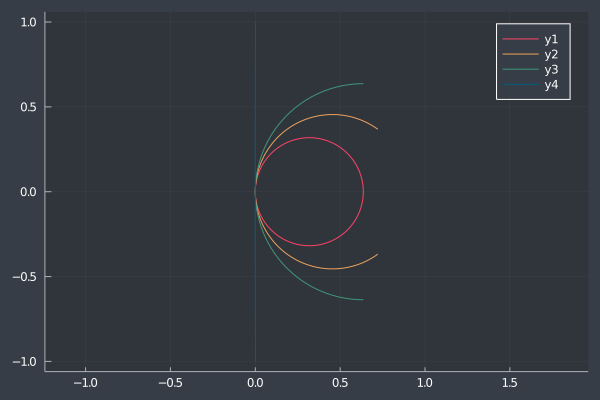

In [313]:
pivot = 0.5
start = [-1,0]
stop = [1,0]

pos_val = zeros(101,2)
for (x_ind, x) in enumerate(0:0.01:1)
    pos_val[x_ind,:] .= getPosOnBentLine(start,stop,x,1,pivot)
end
plot(pos_val[:,1],pos_val[:,2],aspect_ratio=:equal)

pos_val = zeros(101,2)
for (x_ind, x) in enumerate(0:0.01:1)
    pos_val[x_ind,:] .= getPosOnBentLine(start,stop,x,0.7,pivot)
end
plot!(pos_val[:,1],pos_val[:,2],aspect_ratio=:equal)

pos_val = zeros(101,2)
for (x_ind, x) in enumerate(0:0.01:1)
    pos_val[x_ind,:] .= getPosOnBentLine(start,stop,x,0.5,pivot)
end
plot!(pos_val[:,1],pos_val[:,2],aspect_ratio=:equal)

pos_val = zeros(101,2)
for (x_ind, x) in enumerate(0:0.01:1)
    pos_val[x_ind,:] .= getPosOnBentLine(start,stop,x,0.001,pivot)
end
plot!(pos_val[:,1],pos_val[:,2],aspect_ratio=:equal)

In [419]:
# generate an image of a rod with some position, length, position angle,
# and FWHM
function circle_interp2(xcen, ycen, length, pa, fwhm, bent; pivot = 0.5)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    dtor = pi/180
    ux = -sin(pa*dtor)   # 90 deg is up
    uy = cos(pa*dtor)   # 0 deg to the right
    
    start = [xcen-length,ycen]
    stop = [xcen+length,ycen]
    
    rotMat = [ux -uy; uy ux]
    
    pos_val = zeros(101,2)
    for (x_ind, x) in enumerate(0:0.01:1)
        pos_val[x_ind,:] .= rotMat*(getPosOnBentLine(start,stop,x,bent,pivot).-128).+128
    end
    
    mind = ones(nx,nx).*nx^3
    temp = zeros(nx,nx)
    
    for indx = 1:size(pos_val)[1]
        temp .= (sx.-pos_val[indx,1]).^2 .+ (sy.-pos_val[indx,2]).^2
        mind .= min.(mind,temp)
    end

    rodimage = exp.(-(mind)./(2*sig.^2))

    return rodimage
end

circle_interp2 (generic function with 1 method)

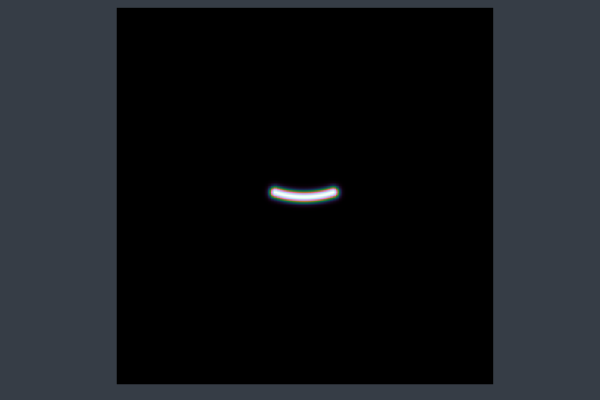

In [445]:
Plots.plot(Plots.heatmap(
    circle_interp2(128,128,20,0,6,0.1),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [481]:
image = zeros(256,256)
export_images = zeros(128*9,128*9)
for (indx_i,i) in enumerate(360:-45:0)
    for (indx_j,j) in enumerate(0:0.125:1)
        image = circle_interp2(128,128,20,i+90,6,j+1e-3)
        export_images[(indx_i-1)*128+1:indx_i*128,(indx_j-1)*128+1:indx_j*128] .= image[64:191,64:191]
    end
end

In [482]:
h5write("../scratch_AKS/paper_data/curves.h5", "main/data", export_images)

In [414]:
@everywhere begin
    using Statistics
    using LinearAlgebra
    using Distributed
    push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
    using DHC_2DUtils
    using FFTW
    using Images
    using Interpolations
    using DSP
    using ProgressMeter
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function circle_interp2(xcen, ycen, length, pa, fwhm, bent; pivot = 0.5)
        nx = 256
        xbox = 1:nx
        ybox = 1:nx
        xbox = xbox.-nx/2 .+xcen
        ybox = ybox.-nx/2 .+ycen

        sx  = xbox' .* ones(size(ybox)[1])
        sy  = ones(size(xbox)[1])' .* ybox

        sig = fwhm/2.355
        dtor = pi/180
        ux = -sin(pa*dtor)   # 90 deg is up
        uy = cos(pa*dtor)   # 0 deg to the right

        start = [xcen-length,ycen]
        stop = [xcen+length,ycen]

        rotMat = [ux -uy; uy ux]

        pos_val = zeros(101,2)
        for (x_ind, x) in enumerate(0:0.01:1)
            pos_val[x_ind,:] .= rotMat*(getPosOnBentLine(start,stop,x,bent,pivot).-128).+128
        end

        mind = ones(nx,nx).*nx^3
        temp = zeros(nx,nx)

        for indx = 1:size(pos_val)[1]
            temp .= (sx.-pos_val[indx,1]).^2 .+ (sy.-pos_val[indx,2]).^2
            mind .= min.(mind,temp)
        end

        rodimage = exp.(-(mind)./(2*sig.^2))

        return rodimage
    end
    
    function perp(val)
        return (-val[2], val[1])
    end

    function getPosOnBentLine(lineStart, lineEnd, t, bendFactor, pivot)
        lineDir = lineEnd - lineStart
        lineLength = sqrt(sum(lineDir.^2))
        circleRad = lineLength / (bendFactor * 2 * pi);
        circleCenter = lineStart .+  (lineEnd .- lineStart)  .* pivot

        angle = pi + bendFactor * (t-pivot) * 2 * pi;
        posOnCircle = circleCenter .+ [cos(angle), sin(angle)] .* circleRad .+ [circleRad,0];

        return posOnCircle
    end
    
    function corner_WST(inputs)
        sig, del = inputs
        image = circle_interp2(128,128,20,sig,6,del+1e-5)
        WST = DHC_compute(image, filter_hash,doS2=false)
        power = sum(image.^2)
        return WST, [sig, del, power]
    end
end
        
rod_DHC_out = @showprogress pmap(corner_WST, Iterators.product(0:1:360,range(0,stop=1,length=361)))
coeff = getindex.(rod_DHC_out, 1);
labels = getindex.(rod_DHC_out, 2);

coeff_out = hcat(coeff...)
labels_out = hcat(labels...)

h5write("../scratch_AKS/paper_data/curve_rod.h5", "main/coeffs", coeff_out)
h5write("../scratch_AKS/paper_data/curve_rod.h5", "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:24:142:49


In [485]:
@everywhere begin
    using Statistics
    using LinearAlgebra
    using Distributed
    push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
    using DHC_2DUtils
    using FFTW
    using Images
    using Interpolations
    using DSP
    using ProgressMeter
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function circle_interp2(xcen, ycen, length, pa, fwhm, bent; pivot = 0.5)
        nx = 256
        xbox = 1:nx
        ybox = 1:nx
        xbox = xbox.-nx/2 .+xcen
        ybox = ybox.-nx/2 .+ycen

        sx  = xbox' .* ones(size(ybox)[1])
        sy  = ones(size(xbox)[1])' .* ybox

        sig = fwhm/2.355
        dtor = pi/180
        ux = -sin(pa*dtor)   # 90 deg is up
        uy = cos(pa*dtor)   # 0 deg to the right

        start = [xcen-length,ycen]
        stop = [xcen+length,ycen]

        rotMat = [ux -uy; uy ux]

        pos_val = zeros(101,2)
        for (x_ind, x) in enumerate(0:0.01:1)
            pos_val[x_ind,:] .= rotMat*(getPosOnBentLine(start,stop,x,bent,pivot).-128).+128
        end

        mind = ones(nx,nx).*nx^3
        temp = zeros(nx,nx)

        for indx = 1:size(pos_val)[1]
            temp .= (sx.-pos_val[indx,1]).^2 .+ (sy.-pos_val[indx,2]).^2
            mind .= min.(mind,temp)
        end

        rodimage = exp.(-(mind)./(2*sig.^2))

        return rodimage
    end
    
    function perp(val)
        return (-val[2], val[1])
    end

    function getPosOnBentLine(lineStart, lineEnd, t, bendFactor, pivot)
        lineDir = lineEnd - lineStart
        lineLength = sqrt(sum(lineDir.^2))
        circleRad = lineLength / (bendFactor * 2 * pi);
        circleCenter = lineStart .+  (lineEnd .- lineStart)  .* pivot

        angle = pi + bendFactor * (t-pivot) * 2 * pi;
        posOnCircle = circleCenter .+ [cos(angle), sin(angle)] .* circleRad .+ [circleRad,0];

        return posOnCircle
    end
    
    function corner_WST(inputs)
        sig, del = inputs
        image = circle_interp2(128,128,40,sig,6,del+1e-5)
        WST = DHC_compute(image, filter_hash,doS2=false)
        power = sum(image.^2)
        return WST, [sig, del, power]
    end
end
        
rod_DHC_out = @showprogress pmap(corner_WST, Iterators.product(0:1:360,range(0,stop=1,length=361)))
coeff = getindex.(rod_DHC_out, 1);
labels = getindex.(rod_DHC_out, 2);

coeff_out = hcat(coeff...)
labels_out = hcat(labels...)

h5write("../scratch_AKS/paper_data/curve_rod_40.h5", "main/coeffs", coeff_out)
h5write("../scratch_AKS/paper_data/curve_rod_40.h5", "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:25:060:17


In [508]:
@everywhere begin
    using Statistics
    using LinearAlgebra
    using Distributed
    push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
    using DHC_2DUtils
    using FFTW
    using Images
    using Interpolations
    using DSP
    using ProgressMeter
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function circle_interp2(xcen, ycen, length, pa, fwhm, bent; pivot = 0.5)
        nx = 256
        xbox = 1:nx
        ybox = 1:nx
        xbox = xbox.-nx/2 .+xcen
        ybox = ybox.-nx/2 .+ycen

        sx  = xbox' .* ones(size(ybox)[1])
        sy  = ones(size(xbox)[1])' .* ybox

        sig = fwhm/2.355
        dtor = pi/180
        ux = -sin(pa*dtor)   # 90 deg is up
        uy = cos(pa*dtor)   # 0 deg to the right

        start = [xcen-length,ycen]
        stop = [xcen+length,ycen]

        rotMat = [ux -uy; uy ux]

        pos_val = zeros(101,2)
        for (x_ind, x) in enumerate(0:0.01:1)
            pos_val[x_ind,:] .= rotMat*(getPosOnBentLine(start,stop,x,bent,pivot).-128).+128
        end

        mind = ones(nx,nx).*nx^3
        temp = zeros(nx,nx)

        for indx = 1:size(pos_val)[1]
            temp .= (sx.-pos_val[indx,1]).^2 .+ (sy.-pos_val[indx,2]).^2
            mind .= min.(mind,temp)
        end

        rodimage = exp.(-(mind)./(2*sig.^2))

        return rodimage
    end
    
    function perp(val)
        return (-val[2], val[1])
    end

    function getPosOnBentLine(lineStart, lineEnd, t, bendFactor, pivot)
        lineDir = lineEnd - lineStart
        lineLength = sqrt(sum(lineDir.^2))
        circleRad = lineLength / (bendFactor * 2 * pi);
        circleCenter = lineStart .+  (lineEnd .- lineStart)  .* pivot

        angle = pi + bendFactor * (t-pivot) * 2 * pi;
        posOnCircle = circleCenter .+ [cos(angle), sin(angle)] .* circleRad .+ [circleRad,0];

        return posOnCircle
    end
    
    function corner_WST(inputs)
        sig, del = inputs
        image = circle_interp2(128,128,40,sig,10,del+1e-5)
        WST = DHC_compute(image, filter_hash,doS2=false)
        power = sum(image.^2)
        return WST, [sig, del, power]
    end
end
        
rod_DHC_out = @showprogress pmap(corner_WST, Iterators.product(0:1:360,range(0,stop=1,length=361)))
coeff = getindex.(rod_DHC_out, 1);
labels = getindex.(rod_DHC_out, 2);

coeff_out = hcat(coeff...)
labels_out = hcat(labels...)

h5write("../scratch_AKS/paper_data/curve_rod_40_10.h5", "main/coeffs", coeff_out)
h5write("../scratch_AKS/paper_data/curve_rod_40_10.h5", "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:22:503:12


In [439]:
filter_temp1 = fink_filter_bank(1,8,nx=256,wd=2);

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 4.329780281177467e-17 0.0; 0.0 0.0 … 0.24764215046180965 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.7071067811865476 4.329780281177467e-17; 0.0 0.0 … 0.9584744990424366 0.5000000000000001; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[1.0 1.0 … 0.0 1.0; 1.0 0.7071067811865476 … 0.0 0.7071067811865476; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.7071067811865476 … 0.0 0.7071067811865476], Dict{String,Any}("theta_value" => [0.0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 1.9634954084936207, 2.356194490192345, 2.748893571891069],"pc" => 1,"wd" => [2.0, 2.0, 2.0, 2.0, 2.0, 2.0],"fs_center_r" => [64.0, 32.0, 16.0, 8.0, 4.0, 2.0],"npix" => 256,"psi_index" => Int32[1 7 … 37 43; 2 8 … 38 44; … ; 5

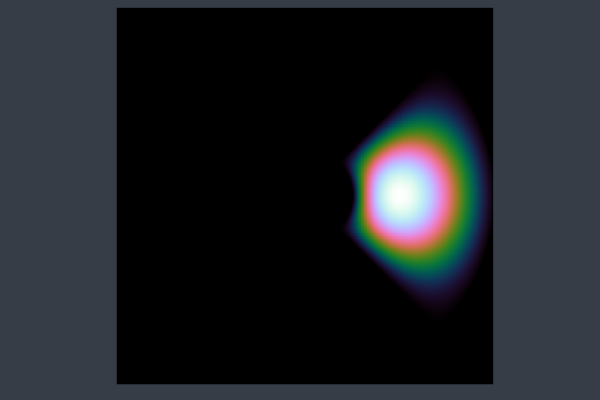

In [443]:
Plots.plot(Plots.heatmap(
    fftshift(filter_temp1[1][:,:,1]),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:cubehelix,
    legend = :none,
    margin=0mm))

In [470]:
out1 = corner_WST(90,0.001)

(Any[0.004520470472195046, 0.0030471904215120167, 0.00017679742920858734, 0.02545722809958391, 0.12097014637625705, 0.11703601444331242, 0.05140952958913282, 0.01495129165636145, 9.580154795780545e-5, 0.013742446466116944  …  0.008256663558432907, 0.01550164746189001, 0.011861306751485653, 1.9328256733166693e-5, 0.002505489891990356, 0.015562026251112943, 0.027756932160579537, 0.026863946783867155, 0.013326883365424456, 0.029813773626271068], 201.03987690222385)

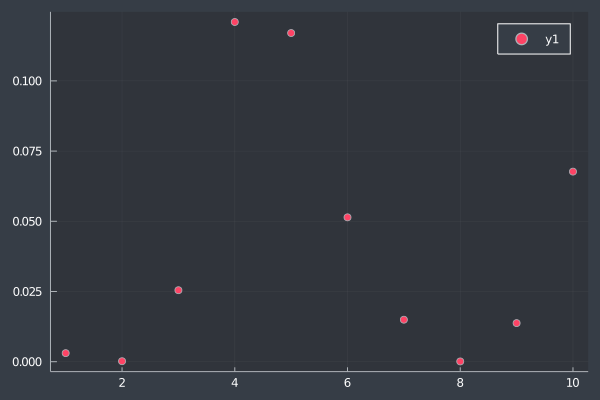

In [471]:
scatter(out1[1][2:11])

In [494]:
function circle_a(xcen, ycen, length, pa, fwhm)
    nx = 256
    xbox = 1:nx
    ybox = 1:nx
    xbox = xbox.-nx/2 .+xcen
    ybox = ybox.-nx/2 .+ycen
    
    sx  = xbox' .* ones(size(ybox)[1])
    sy  = ones(size(xbox)[1])' .* ybox

    sig = fwhm/2.355
    
    r = sqrt.(sx.^2 + sy.^2)
    
    r[r.-length.<0] .= 0
    r .= min.(abs.(r.-length),r)

    rodimage = exp.(-(r.^2)./(2*sig.^2))

    return rodimage
end

circle_a (generic function with 1 method)

In [501]:
export_images = zeros(128*9,128*9)
for (indx_i,i) in enumerate(2 .^(range(-1,stop=5,length=9)))
    for (indx_j,j) in enumerate(range(0.5,stop=16,length=9))
        image = circle_a(0,0,i,0,j)
        export_images[(indx_i-1)*128+1:indx_i*128,(indx_j-1)*128+1:indx_j*128] .= image[64:191,64:191]
    end
end

In [502]:
h5write("../scratch_AKS/paper_data/discs.h5", "main/data", export_images)

In [507]:
@everywhere begin
    using Statistics
    using LinearAlgebra
    using Distributed
    push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
    using DHC_2DUtils
    using FFTW
    using Images
    using Interpolations
    using DSP
    using ProgressMeter
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function circle_a(xcen, ycen, length, pa, fwhm)
        nx = 256
        xbox = 1:nx
        ybox = 1:nx
        xbox = xbox.-nx/2 .+xcen
        ybox = ybox.-nx/2 .+ycen

        sx  = xbox' .* ones(size(ybox)[1])
        sy  = ones(size(xbox)[1])' .* ybox

        sig = fwhm/2.355

        r = sqrt.(sx.^2 + sy.^2)

        r[r.-length.<0] .= 0
        r .= min.(abs.(r.-length),r)

        rodimage = exp.(-(r.^2)./(2*sig.^2))

        return rodimage
    end
    
    function corner_WST(inputs)
        i, j = inputs
        image = circle_a(0,0,i,0,j)
        WST = DHC_compute(image, filter_hash,doS2=false)
        power = sum(image.^2)
        return WST, [i, j, power]
    end
end
        
rod_DHC_out = @showprogress pmap(corner_WST, Iterators.product(2 .^(range(-1,stop=6,length=361)),range(0.5,stop=16,length=361)))
coeff = getindex.(rod_DHC_out, 1);
labels = getindex.(rod_DHC_out, 2);

coeff_out = hcat(coeff...)
labels_out = hcat(labels...)

h5write("../scratch_AKS/paper_data/disc_data.h5", "main/coeffs", coeff_out)
h5write("../scratch_AKS/paper_data/disc_data.h5", "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:20:08
